# Question 1: Trinomial Interest Rate Tree

## Part 1

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(10)

R0 = .03
p = np.array([.3, .3, .4])
N = 12
M = 1000
R = np.zeros((M,N))
R[:,0] = R0
u = .0025
d = -.0025

# Run M simulations of the interest rate of N periods
for m in range(M):
    for n in range(1, N):
        draw = np.random.choice(
            a = np.array([u, 0, d]),
            p = p
        )
        R[m,n] = R[m, n-1] + draw

## Part 2

In [72]:
# Second Dimension is N-1 since we ignore T=0 case
B = np.zeros((M,N))
B_est = np.zeros(N)

# For each maturity
for T in range(N):
    # Determine bond price for each simulation of maturity T
    for m in range(M):
        B[m,T] = 1/np.prod((1+R[m,:T+1]))
    
    # Determine the MC estimate (average) for each T
    B_est[T] = np.mean(B[:,T])

## Part 3

In [73]:
yields = np.zeros(N)

for i in range(len(yields)):
    yields[i] = (1/B_est[i])**(1/(i+1)) - 1

pd.DataFrame({'B(0,T)':B_est, 'yield': yields}, index=range(1,N+1))

,"B(0,T)",yield
1,0.970874,0.030000
2,0.942870,0.029850
3,0.915799,0.029754
4,0.889675,0.029656
5,0.864540,0.029539
6,0.840289,0.029426
7,0.816862,0.029320
8,0.794238,0.029215
9,0.772461,0.029101
10,0.751493,0.028981


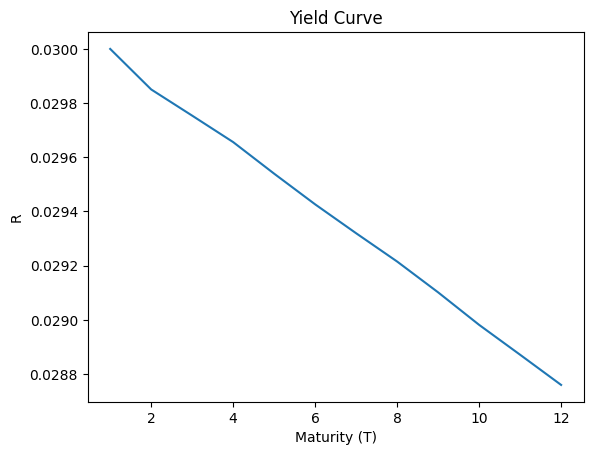

In [74]:
plt.plot(range(1,N+1), yields)
plt.title('Yield Curve')
plt.ylabel('R')
plt.xlabel('Maturity (T)')
plt.show()

# Question 2:

#### Continuous Time Interest Rate Modeling: Vasicek model for pricing a set of floor payments

In [75]:
from numpy import exp, sqrt
from scipy.stats import norm

M = 1000
T = 3
h = 1/24 # Simulation period length
kappa = 2
r_bar = .05
sigma = .04
N = 1/h * T # Number of time steps
K = .03
R0 = .04

R = np.zeros((M,int(N) + 1))
R[:, 0] = R0

B_n = np.zeros((M,3))
floor_price = np.zeros(M)

# Simulate the interest rate process
for m in range(M):
    for n in range(1,int(N)+1):
        Z = norm.rvs()
        R[m,n] = (exp(-kappa*h) * R[m,n-1] + 
            (1-exp(-kappa*h))*r_bar + 
            sqrt(1-exp(-2*kappa*h)) * sqrt(sigma**2/(2*kappa))*Z)

    # Determine the zero-coupon bond price at T=1,2,3 which is
    # n=24,48,72 respectively
    for n in range(24,73,24):
        B_n[m, int(n/24-1)] = exp(-np.sum(R[m,:n] * h))
    
    floor_price[m] = np.sum(B_n[m,:] * np.maximum(K - R[m,n-1],0))

estimate = np.mean(floor_price)
print(round(estimate,3))

0.005


# Question 3:

#### Uniform Stratified Sampling

## Part 0

#### First lets compute the estimate and confidence interval for a regular monte carlo simulation

In [77]:
from scipy.stats import norm
from numpy import exp, sqrt

S0 = 60
r = .04
T = 1
sigma = .25
K = 65
n = 400 # number of samples

Z = norm.rvs(size=n)

S_T = S0 * exp( (r - sigma**2/2)*T + sigma*sqrt(T)*Z)
payoff = np.maximum(S_T - K, 0)

estimate = np.average(payoff)
mc_error = np.std(payoff)

lb = estimate - 1.96 * mc_error/n**.5
ub = estimate + 1.96 * mc_error/n**.5

print(f"The Monte Carlo Price estimate for this security is: {round(estimate,2)}")
print("")
print(f"The standard error of the estimate is: {round(mc_error,2)}")
print("")
print("A 95% confidence interval is:")
print(f"{round(lb,2)} - {round(ub,2)}")

The Monte Carlo Price estimate for this security is: 5.39

The standard error of the estimate is: 10.37

A 95% confidence interval is:
4.38 - 6.41


## Part 1

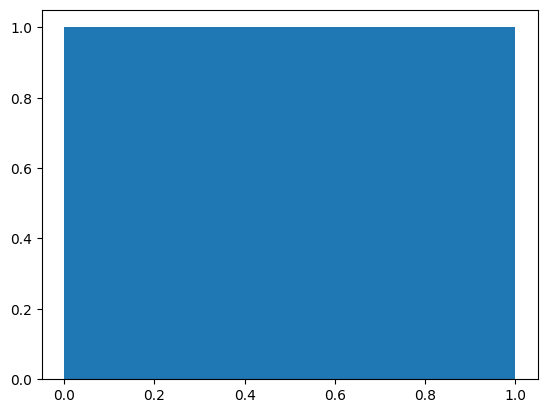

In [78]:
from numpy.random import uniform

U = uniform(size=n)
V = np.zeros(n) # array that holds stratified samples

for i in range(1,n+1):
    V[i-1] = (i - 1 + U[i-1]) / n

# Ensure stratified sampling went well
plt.hist(V, bins=np.linspace(0,1,n+1))
plt.show()

## Part 2

In [79]:
from scipy.stats import norm

# Here we convert our stratified uniform samples into 
# stratified standard normal random variables

W = norm.ppf(V)

## Part 3

In [80]:
S_T = S0 * exp( (r - sigma**2/2)*T + sigma*sqrt(T)*W)
payoff = np.maximum(S_T - K, 0)

estimate = np.average(payoff)
mc_error = np.std(payoff)

lb = estimate - 1.96 * mc_error/n**.5
ub = estimate + 1.96 * mc_error/n**.5

print(f"The Monte Carlo Price estimate for this security is: {round(estimate,2)}")
print("")
print(f"The standard error of the estimate is: {round(mc_error,2)}")
print("")
print("A 95% confidence interval is:")
print(f"{round(lb,2)} - {round(ub,2)}")

The Monte Carlo Price estimate for this security is: 5.18

The standard error of the estimate is: 10.0

A 95% confidence interval is:
4.2 - 6.16


We notice that we reduced standard error from 9.99 to 9.63 using the same number of simulations.

# Question 4:

#### Non-uniform Sratified Sampling

In [81]:
N1 = 40
N2, N3, N4 = (120, 120, 120)

A1 = uniform(low=0, high=.3, size=N1)
A2 = uniform(low=.3, high=.6, size=N2)
A3 = uniform(low=.6, high=.8, size=N3)
A4 = uniform(low=.8, high=1, size=N4)

U = np.append(A1, [A2, A3, A4])
Z = norm.ppf(U)

S_T = S0 * exp( (r - sigma**2/2) + sigma*sqrt(T)*Z)
payoff = np.maximum(S_T - K, 0)

estimate = np.average(payoff)
mc_error = np.std(payoff)

lb = estimate - 1.96 * mc_error/n**.5
ub = estimate + 1.96 * mc_error/n**.5

print(f"The Monte Carlo Price estimate for this security is: {round(estimate,2)}")
print("")
print(f"The standard error of the estimate is: {round(mc_error,2)}")
print("")
print("A 95% confidence interval is:")
print(f"{round(lb,2)} - {round(ub,2)}")

The Monte Carlo Price estimate for this security is: 7.77

The standard error of the estimate is: 10.82

A 95% confidence interval is:
6.71 - 8.83


We notice that non-uniform stratification (i.e. strata that have wide intervals which allows for more randomness) shows worse performance as judged by standard error compared to uniform stratification. This is probably due to the fact that the splits were not proportional to the probabilities: strata 1 had 40 samples while the other three had 120. Also, the strata were not of the same size. This led to a disproportionate amount of other strata relative to others, which led to more deviation among payoffs.